In [1]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas
import seaborn as sns

In [2]:
# load training feature data (X)
Xtr = np.load("train_features.npy")

# load corresponding training labels
ytr = np.load("train_labels.npy")

# total number of classes
num_classes = np.max(ytr) + 1
class_names=['battery','biological','cardboard','clothes','glass','metal','paper','plastic','shoes','trash']


# standardize features by removing the mean and scaling unit variance
scaler=StandardScaler()
Xtr=scaler.fit_transform(Xtr)

In [3]:
class MLP_Simple(nn.Module):
    def __init__(self, input_size, output_size=num_classes, hidden_size=128, dropout_prob=0.1):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

In [4]:
class MLP_Improved(nn.Module):
    def __init__(self, input_size, reduced_size=2048, hidden1=1024, hidden2=512, output_size=num_classes, dropout_prob=0.2):
        super().__init__()
        self.fc_reduce = nn.Linear(input_size, reduced_size)
        self.fc1 = nn.Linear(reduced_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.out = nn.Linear(hidden2, output_size)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = F.relu(self.fc_reduce(x))
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

In [5]:
num_epochs=100
lr=0.0005
batch_size=32

In [6]:
Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.long)

# Wrap Xtr and ytr into a dataset
train_dataset = TensorDataset(Xtr, ytr)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP_Simple(input_size=Xtr.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()  # for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=lr)

# uncomment to load the already trained model
#model.load_state_dict(torch.load("mlpSIMPLE_modelweights.pth"))


In [8]:
# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP_Improved(input_size=Xtr.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()  # for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=lr)

# uncomment to load the already trained model
model.load_state_dict(torch.load("mlpIMPROVED_modelweights.pth"))


<All keys matched successfully>

In [ ]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_x, batch_y in train_dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        logits = model(batch_x)
        loss = criterion(logits, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

In [ ]:
## Save model weights
#torch.save(model.state_dict(), "mlpIMPROVED_modelweights.pth")
#torch.save(model.state_dict(), "mlpSIMPLE_modelweights.pth")

In [9]:
Xtr = Xtr.to(device)
ytr = ytr.to(device)

model = model.to(device)
model.eval()  # set model to evaluation mode


with torch.no_grad():  # disable gradient computation
    logits = model(Xtr)                 # forward pass
    preds = torch.argmax(logits, dim=1)          # get class indices

y_true = ytr.cpu().numpy()  # true labels
y_pred = preds.cpu().numpy()         # predicted labels

# Overall metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')  # weighted accounts for class imbalance
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9477
Precision: 0.9503
Recall: 0.9477
F1 Score: 0.9473


Accuracy: 0.7054
Precision: 0.7200
Recall: 0.7054
F1 Score: 0.7032


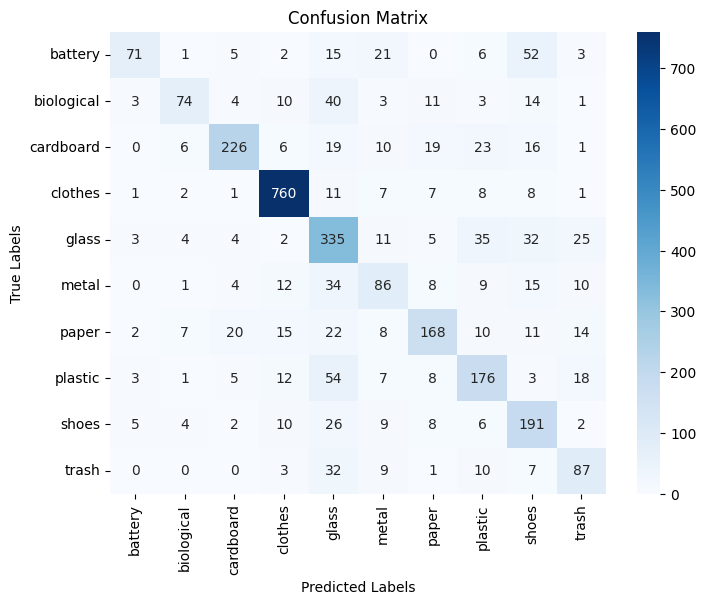

In [10]:
Xtest_studio = np.load("test_studio_features.npy")
ytest_studio = np.load("test_studio_labels.npy")

Xtest_studio = scaler.transform(Xtest_studio)
Xtest_studio = torch.tensor(Xtest_studio, dtype=torch.float32)
ytest_studio = torch.tensor(ytest_studio , dtype=torch.long)

Xtest_studio = Xtest_studio.to(device)
ytest_studio = ytest_studio.to(device)

model = model.to(device)
model.eval()  # set model to evaluation mode


with torch.no_grad():  # disable gradient computation
    logits = model(Xtest_studio)                 # forward pass
    preds = torch.argmax(logits, dim=1)          # get class indices

y_true = ytest_studio.cpu().numpy()  # true labels
y_pred = preds.cpu().numpy()         # predicted labels

# Overall metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')  # weighted accounts for class imbalance
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion matrix and plot
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
Xtest_realworld = np.load("test_realworld_features.npy")
ytest_realworld = np.load("test_realworld_labels.npy")

Xtest_realworld = scaler.transform(Xtest_realworld)
Xtest_realworld= torch.tensor(Xtest_realworld, dtype=torch.float32)
ytest_realworld = torch.tensor(ytest_realworld , dtype=torch.long)

Xtest_realworld = Xtest_realworld.to(device)
ytest_realworld = ytest_realworld.to(device)

model = model.to(device)
model.eval()  # set model to evaluation mode

with torch.no_grad():  # disable gradient computation
    logits = model(Xtest_realworld)                 # forward pass
    preds = torch.argmax(logits, dim=1)          # get class indices


from sklearn.metrics import accuracy_score, classification_report

y_true = ytest_realworld.cpu().numpy()  # true labels
y_pred = preds.cpu().numpy()         # predicted labels


# Overall metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')  # weighted accounts for class imbalance
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion matrix and plot
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
